In [4]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from BGWOPSO import BGWOPSO
# from GWO import GWO
import functools
import pickle

In [5]:
data = pd.read_csv("./data/employee.csv")
attrition = data["Attrition"]
data = data.drop("Attrition",axis=1)
data["Attrition"] = attrition
# data.to_csv("./data/employee_class_right.csv", index=False)
data.shape

(1470, 35)

In [6]:
# data["Attrition"].value_counts()

In [7]:
# data.nunique()

In [8]:
# data.describe()

In [9]:
# data.info()

In [10]:
objectList = data.select_dtypes(include = "object").columns.to_list()
nonObjectList = data.select_dtypes(exclude="object").columns.to_list()

In [11]:
for x in ["Education", 'EnvironmentSatisfaction', "JobInvolvement", "JobLevel", "JobSatisfaction", "PerformanceRating", "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance"]:
    nonObjectList.remove(x)
    objectList.append(x)

In [12]:
# print(nonObjectList)
# print(objectList)

In [13]:
le = LabelEncoder()
data_encoded = data.copy()

for object in objectList:
    le.fit(data[object])
    data_encoded[object] = le.transform(data[object])
    # pickle.dump(le, open('./model/encode/{}.pkl'.format(object), 'wb'))

# data.to_csv("./data/data_encoded.csv", index=False)
# pickle.dump(scaler, open('./model/minmaxscaler.pkl', 'wb'))
# data_encoded

In [14]:
# np.sort(data_encoded['MonthlyIncome'].unique())

In [15]:
scaler = MinMaxScaler()
data_normalized = data.copy()

for column in data_encoded.columns:
    scaler.fit(data_encoded[column].values.reshape(-1,1))
    data_normalized[column] = scaler.transform(data_encoded[column].values.reshape(-1,1))
#     pickle.dump(scaler, open('./model/scale/{}.pkl'.format(column), 'wb'))
# data_normalized.to_csv("./data/data_normalized.csv", index=False)
# data_normalized

In [16]:
X = data_normalized.drop("Attrition", axis=1).values
y = data_normalized["Attrition"].values

In [17]:
cat_index = [data_normalized.columns.get_loc(c) for c in objectList if c in data_normalized.drop('Attrition', axis=1)]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)
# X_train.to_csv("./data/X_train.csv")

### Seleksi Fitur BGWOPSO

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [20]:
def fitness(x, X_train, X_test, y_train, y_test):
    alpha = 0.99
    beta = 1-alpha
    if x.ndim == 1:
        x = x.reshape(1, -1)
    loss = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        if np.sum(x[i, :]) > 0:
            model = SVC(C=10, gamma=0.1, kernel='rbf')
            model.fit(X_train[:, x[i,:].astype(bool)], y_train)
            acc = model.score(X_test[:, x[i,:].astype(bool)], y_test)
            error_rate = 1 - acc
            loss[i] = alpha * error_rate + beta * (np.sum(x[i, :]) / X.shape[1])
        else:
            loss[i] = np.inf
    return loss

In [21]:
lossfunc_bgwopso = functools.partial(fitness, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
optimizer_bgwopso = BGWOPSO(lossfunc_bgwopso, X_train.shape[1], 8, 70)
optimizer_bgwopso.opt()
selected_features_bgwopso = optimizer_bgwopso.gBest_X.astype(bool)
print(selected_features_bgwopso)

[ 1.60144532  0.61845454  0.02559287  0.96576098  1.46147053  0.11487318
  1.08011407  0.04493805  0.50519952  0.6211255   0.21317951  0.60712241
  1.17275865  1.01093083  1.09198628  0.87746488  1.19297656  1.17415549
  1.03401165  0.12502933 -0.43912786  1.06852289  0.8890102   0.2523591
  0.24181025  0.68269579  1.61164147  1.09858576  0.65697997  0.41609731
  0.57783158  1.17003482 -0.12492567  0.76493998]
[1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
[ 1.07717332  0.80374776  0.03516524  0.29307622  0.91443023 -0.10180933
  1.53158634  0.24389935  0.96955371  0.12679692  0.73206668  0.74024026
  0.01983931  0.91288759  0.98788435  0.89122948  1.06701482  1.12195512
  0.83936643  0.63887905  0.45501108  0.4551476   0.86150382  0.19207133
  0.45901706 -0.0116464   1.27498154  1.11293163  1.23266777 -0.04326519
  0.36104548  0.99500661 -0.15631199  0.82751289]
[1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.

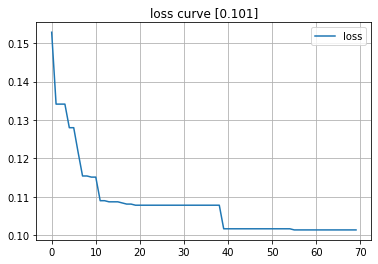

In [26]:
optimizer_bgwopso.plot_curve()

In [ ]:
np.array([3,4,5]).reshape(1, -1).shape

In [22]:
data_selected = data.loc[:, np.append(selected_features_bgwopso, True)]
# data_selected.to_csv("./data/data_selected.csv", index=False)

In [ ]:
# data_train = pd.DataFrame(X_train[:, selected_features_bgwopso])
# data_train[data.columns[-1]] = y_train
# data_train.columns = data_selected.columns
# data_train.to_csv("./data/data_train.csv", index=False)

# data_test = pd.DataFrame(X_test[:, selected_features_bgwopso])
# data_test[data.columns[-1]] = y_test
# data_test.columns = data_selected.columns
# data_test.to_csv("./data/data_test.csv", index=False)

In [25]:
# print("list of all selected features: ")
# for i, feature in enumerate(data.columns[np.where(selected_features_bgwopso)], start=1):
for i, feature in enumerate(data_selected):
    print(f"{i}. {feature}")

0. BusinessTravel
1. DailyRate
2. Department
3. DistanceFromHome
4. EducationField
5. EmployeeNumber
6. EnvironmentSatisfaction
7. Gender
8. JobLevel
9. JobRole
10. JobSatisfaction
11. MaritalStatus
12. MonthlyIncome
13. MonthlyRate
14. NumCompaniesWorked
15. OverTime
16. PercentSalaryHike
17. RelationshipSatisfaction
18. StockOptionLevel
19. TotalWorkingYears
20. TrainingTimesLastYear
21. YearsInCurrentRole
22. YearsSinceLastPromotion
23. YearsWithCurrManager
24. Attrition


In [ ]:
# 1. BusinessTravel
# 2. DailyRate
# 3. Department
# 4. DistanceFromHome
# 5. EducationField
# 6. EmployeeNumber
# 7. EnvironmentSatisfaction
# 8. Gender
# 9. JobLevel
# 10. JobRole
# 11. JobSatisfaction
# 12. MaritalStatus
# 13. MonthlyIncome
# 14. MonthlyRate
# 15. NumCompaniesWorked
# 16. OverTime
# 17. PercentSalaryHike
# 18. RelationshipSatisfaction
# 19. StockOptionLevel
# 20. TotalWorkingYears
# 21. TrainingTimesLastYear
# 22. YearsInCurrentRole
# 23. YearsSinceLastPromotion
# 24. YearsWithCurrManager

In [24]:
# import pickle

svm3 = SVC(C=1000, gamma=0.01, kernel='rbf')
svm3.fit(X_train[:, selected_features_bgwopso], y_train)
y_pred3 = svm3.predict(X_test[:, selected_features_bgwopso])
# svm3.fit(X_train, y_train)
# y_pred3 = svm3.predict(X_test)
# pickle.dump(svm3, open('./model/svm_model.pkl', 'wb'))


print("Accuracy =", round(accuracy_score(y_test,y_pred3)*100, 2))
print("Precision ", round(precision_score(y_test, y_pred3)*100, 2))
print("Recall / Sensifity ", round(recall_score(y_test, y_pred3)*100, 2))
print("F1 ", round(f1_score(y_test, y_pred3)*100, 2))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred3).ravel()
specificity = tn / (tn+fp)
print("Specificity ", round(specificity*100, 2))
print("TN = ", tn)
print("FP = ", fp)
print("FN = ", fn)
print("TP = ", tp)

Accuracy = 88.44
Precision  73.33
Recall / Sensifity  45.83
F1  56.41
Specificity  96.75
TN =  119
FP =  4
FN =  13
TP =  11


In [ ]:
# evaluasi_test_data = data_test.copy()
# evaluasi_test_data["Predicted"] = y_pred3
# evaluasi_test_data.to_csv("./data/evaluasi_test_data.csv", index=False)

In [ ]:
# from sklearn import metrics
# import matplotlib.pyplot as plt
# confusion_matrix = metrics.confusion_matrix(y_test, y_pred3)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# cm_display.plot()
# plt.savefig("./images/confusion_matrix_employee.jpg")

In [ ]:
# predicted = ["predicted_false", "predicted_true"]
# actual = ["actual_false", "actual_true"]
# df_cf = pd.DataFrame(columns = predicted, index = actual)
# df_cf["predicted_false"] = [tn, fn]
# df_cf["predicted_true"] = [fp, tp]

In [ ]:
# # C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# # g = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# C = [1, 10, 100, 1000]
# g = [0.001, 0.01, 0.1, 1]
# df_acc = pd.DataFrame(columns = C, index = g)
# df_prec = pd.DataFrame(columns = C, index = g)
# df_sens = pd.DataFrame(columns = C, index = g)
# df_f1 = pd.DataFrame(columns = C, index = g)
# df_spec = pd.DataFrame(columns = C, index = g)

# for i in C:
#     for j in g:
#         # print(i, j)
#         svm3 = SVC(C=i, gamma=j, kernel='rbf')
#         # svm3 = SVC(C=i, gamma=j, kernel='poly')
#         # svm3 = SVC(C=i, gamma=j, kernel='sigmoid')
#         svm3.fit(X_train[:, selected_features_bgwopso], y_train)
#         y_pred3 = svm3.predict(X_test[:, selected_features_bgwopso])
#         # svm3.fit(X_train, y_train)
#         # y_pred3 = svm3.predict(X_test)

#         accuracy = round(accuracy_score(y_test,y_pred3)*100, 2)
#         df_acc[i][j] = accuracy
        
#         precision = round(precision_score(y_test, y_pred3)*100, 2)
#         df_prec[i][j] = precision

#         sensifity = round(recall_score(y_test, y_pred3)*100, 2)
#         df_sens[i][j] = sensifity

#         F1 = round(f1_score(y_test, y_pred3)*100, 2)
#         df_f1[i][j] = F1

#         tn, fp, fn, tp = confusion_matrix(y_test, y_pred3).ravel()
#         specificity = round(tn/(tn+fp)*100, 2)
#         df_spec[i][j] = specificity

# print("Accuracy")
# print(df_acc)
# df_acc.to_excel("cm/accuracy.xlsx")

# print("Precision")
# print(df_prec)
# df_prec.to_excel("cm/precision.xlsx")

# print("Sensifity")
# print(df_sens)
# df_sens.to_excel("cm/sensifity.xlsx")

# print("F1 Score")
# print(df_f1)
# df_f1.to_excel("cm/f1.xlsx")

# print("Specifity") 
# print(df_spec) 
# df_spec.to_excel("cm/specifity.xlsx")


In [ ]:
# from sklearn.svm import LinearSVC

# matrix_list = ["Accuracy", "Precision", "Sensifity", "F1", "Specificity"]
# df_svm_linear = pd.DataFrame(columns = C, index = matrix_list)

# for i in C:
#     svm3 = LinearSVC(C=i)
#     # svm3 = SVC(C=i, gamma=j, kernel='linear')
#     svm3.fit(X_train[:, selected_features_bgwopso], y_train)
#     y_pred3 = svm3.predict(X_test[:, selected_features_bgwopso])
#     # svm3.fit(X_train, y_train)
#     # y_pred3 = svm3.predict(X_test)

#     accuracy = round(accuracy_score(y_test,y_pred3)*100, 2)
#     df_svm_linear[i]["Accuracy"] = accuracy
    
#     precision = round(precision_score(y_test, y_pred3)*100, 2)
#     df_svm_linear[i]["Precision"] = precision

#     sensifity = round(recall_score(y_test, y_pred3)*100, 2)
#     df_svm_linear[i]["Sensifity"] = sensifity

#     F1 = round(f1_score(y_test, y_pred3)*100, 2)
#     df_svm_linear[i]["F1"] = F1

#     tn, fp, fn, tp = confusion_matrix(y_test, y_pred3).ravel()
#     specificity = round(tn/(tn+fp)*100, 2)
#     df_svm_linear[i]["Specificity"] = specificity

# df_svm_linear.to_excel("cm/matrix_svm_linear.xlsx")
# print(df_svm_linear)

In [ ]:
# evaluasi_test_data = pd.DataFrame(X_test[:, selected_features_bgwopso])
# evaluasi_test_data.columns = data.columns[np.where(selected_features_bgwopso)]
# evaluasi_test_data["Actual"] = y_test
# evaluasi_test_data["Predicted"] = y_pred3
# evaluasi_test_data.to_excel("evaluasi_test_data.xlsx")

### Seleksi Fitur GWO

In [ ]:
# lossfunc_gwo = functools.partial(fitness, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
# fit_optimizer_gwo = GWO(lossfunc_gwo, 0, 1, X_train.shape[1], 10, 20)
# selected_features_gwo = np.where(fit_optimizer_gwo>0.5)[0]
# print(selected_features_gwo)

In [ ]:
# svm2 = SVC(C=10, gamma=0.1, kernel='rbf')
# svm2.fit(X_train[:, selected_features_gwo], y_train)
# y_pred2 = svm2.predict(X_test[:, selected_features_gwo])

# print("Accuracy ", accuracy_score(y_test,y_pred2))
# print("Precision ", precision_score(y_test, y_pred2))
# print("Recall / Sensifity ", recall_score(y_test, y_pred2))
# print("F1 ", f1_score(y_test, y_pred2))
# tn, fp, fn, tp = confusion_matrix(y_test, y_pred2).ravel()
# specificity = tn / (tn+fp)
# print("Specificity ", specificity)

In [ ]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)
# print(X_test[:, selected_features_gwo])

### Tanpa Seleksi Fitur

In [ ]:
# svm1 = SVC(C=10, gamma=0.1, kernel='rbf')
# svm1.fit(X_train, y_train).score(X_test, y_test)
# y_pred1 = svm1.predict(X_test)

# print("Accuracy ", accuracy_score(y_test,y_pred1))
# print("Precision ", precision_score(y_test, y_pred1))
# print("Recall / Sensifity ", recall_score(y_test, y_pred1))
# print("F1 ", f1_score(y_test, y_pred1))
# tn, fp, fn, tp = confusion_matrix(y_test, y_pred1).ravel()
# specificity = tn / (tn+fp)
# print("Specificity ", specificity)

In [ ]:
# print("list of all selected features: ")
# for i, feature in enumerate(data.columns[np.where(selected_features_gwo)], start=1):
#     print(f"{i}. {feature}")

### PSO

In [ ]:

# from Fitness import Data
# import PSO

# d = Data('employee_class_on_right.csv',False, 3) # Object for Data
# dim = d.getDimension()  # Dimensionality of the Features
# selected_pso = PSO.run(d,dim,3) # invoking
# selected_pso_bool = selected_pso.astype(bool)
# print(selected_pso_bool)

In [ ]:
# svm4 = SVC(C=10, gamma=0.1, kernel='rbf')
# svm4.fit(X_train[:, selected_pso_bool], y_train)
# y_pred4 = svm4.predict(X_test[:, selected_pso_bool])

# print("Accuracy ", accuracy_score(y_test,y_pred4))
# print("Precision ", precision_score(y_test, y_pred4))
# print("Recall / Sensifity ", recall_score(y_test, y_pred4))
# print("F1 ", f1_score(y_test, y_pred4))
# tn, fp, fn, tp = confusion_matrix(y_test, y_pred4).ravel()
# specificity = tn / (tn+fp)
# print("Specificity ", specificity)